In [15]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.metrics import classification_report            # Summary of classifier performance

from utils import get_df, evaluate_classifier

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}

# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 43.7 ms


In [3]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 319 ms


In [4]:
ds.close()

time: 20.6 ms


In [5]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 8.9 s


In [6]:
# Create the df format to be used by scikit-learn
for i, polarization in enumerate(['VV', 'VH', 'VV-VH']):
    df_polarization = get_df(polygons_year=2019, 
                             satellite_dates=slice('2018-01-01', '2019-12-31'), 
                             fields='all', 
                             satellite='all', 
                             polarization=polarization,
                             netcdf_path=netcdf_path)
    
    # Extract a mapping of field_ids to crop type
    if i == 0:
        df_sklearn = df_polarization[['field_id', 'afgkode', 'afgroede']]
    
    # Pivot the df (https://stackoverflow.com/a/37790707/12045808)
    df_polarization = df_polarization.pivot(index='field_id', columns='date', values='stats_mean')
    
    # Add polarization to column names
    df_polarization.columns = [str(col)[:10]+f'_{polarization}' for col in df_polarization.columns]  
    
    # Merge the polarization dataframes into one dataframe
    df_polarization = df_polarization.reset_index()  # Creates new indices and a 'field_id' column (field id was used as indices before)
    df_sklearn = pd.merge(df_sklearn, df_polarization, on='field_id') 
        
# Drop fields having nan values
df_sklearn = df_sklearn.dropna()

# The merge operation for some reason made duplicates (there was a bug reported on this earlier), so drop duplicates and re-index the df
df_sklearn = df_sklearn.drop_duplicates().reset_index(drop=True)

time: 28.3 s


In [7]:
#df_sklearn

time: 34.3 ms


In [8]:
#df_sklearn[df_sklearn['afgkode'] == 252].describe()

time: 19.4 ms


In [9]:
#df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
#                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]

df_sklearn_remapped = df_sklearn.copy()

df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1
    
    #df_sklearn = df_sklearn.replace(key, value)
    
for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
print(f"Crop types: {class_names}")

Crop types: ['Potato', 'Spring barley', 'Winter barley', 'Spring wheat', 'Winter wheat', 'Winter rye', 'Spring oat', 'Maize', 'Rapeseed', 'Permanent grass', 'Willow', 'Forest']
time: 228 ms


In [10]:
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

time: 793 ms


In [11]:
# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=RANDOM_SEED)

print(f"Train samples:      {len(y_train)}")
print(f"Test samples:       {len(y_test)}")
print(f"Number of features: {len(X[0,:])}")

Train samples:      31033
Test samples:       13300
Number of features: 231
time: 113 ms


Training time: 19.5514 s
Prediction time: 0.0048 s

Report:

Train accuracy: 1.0
Test accuracy: 0.8462

                  precision    recall  f1-score   support

         Potato       0.95      0.95      0.95      2251
  Spring barley       0.75      0.77      0.76      1187
  Winter barley       0.90      0.90      0.90      1311
   Spring wheat       0.43      0.44      0.44       482
   Winter wheat       0.83      0.84      0.84      1114
     Winter rye       0.87      0.88      0.87      1290
     Spring oat       0.78      0.77      0.77      1340
          Maize       0.91      0.91      0.91      1430
       Rapeseed       0.98      0.98      0.98      1121
Permanent grass       0.76      0.75      0.75      1135
         Willow       0.66      0.66      0.66       251
         Forest       0.79      0.78      0.78       388

       accuracy                           0.85     13300
      macro avg       0.80      0.80      0.80     13300
   weighted avg       0.85      0.85  

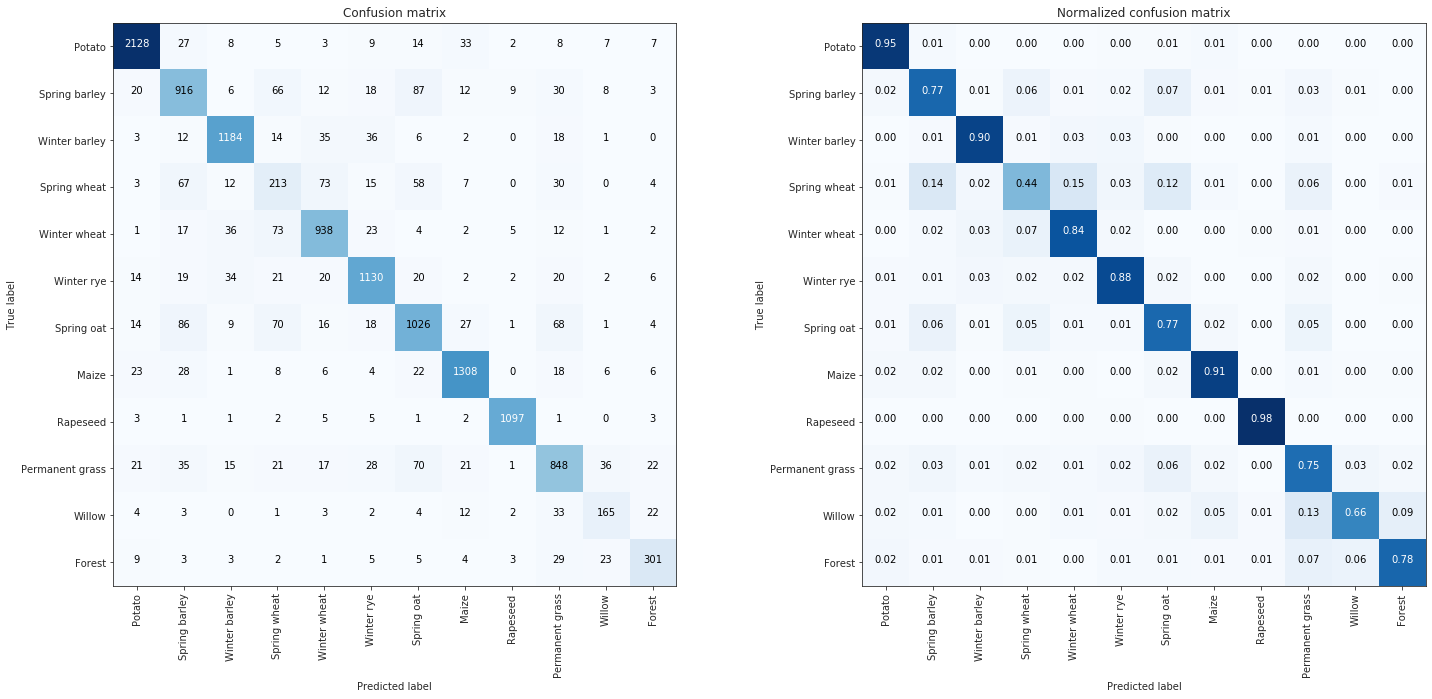

time: 20.9 s


In [102]:
from sklearn.tree import DecisionTreeClassifier              

# Instantiate and evaluate classifier
clf = DecisionTreeClassifier()
clf_trained, _, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=False)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training time: 83.9934 s
Prediction time: 0.0072 s

Report:

Train accuracy: 0.9305
Test accuracy: 0.9223

                  precision    recall  f1-score   support

         Potato       0.97      0.97      0.97      2322
  Spring barley       0.85      0.89      0.87      1150
  Winter barley       0.97      0.97      0.97      1322
   Spring wheat       0.74      0.43      0.54       464
   Winter wheat       0.91      0.96      0.93      1107
     Winter rye       0.95      0.94      0.95      1292
     Spring oat       0.86      0.86      0.86      1338
          Maize       0.95      0.97      0.96      1410
       Rapeseed       0.99      1.00      0.99      1084
Permanent grass       0.86      0.94      0.90      1169
         Willow       0.87      0.82      0.84       262
         Forest       0.90      0.86      0.88       380

       accuracy                           0.92     13300
      macro avg       0.90      0.88      0.89     13300
   weighted avg       0.92      0.9

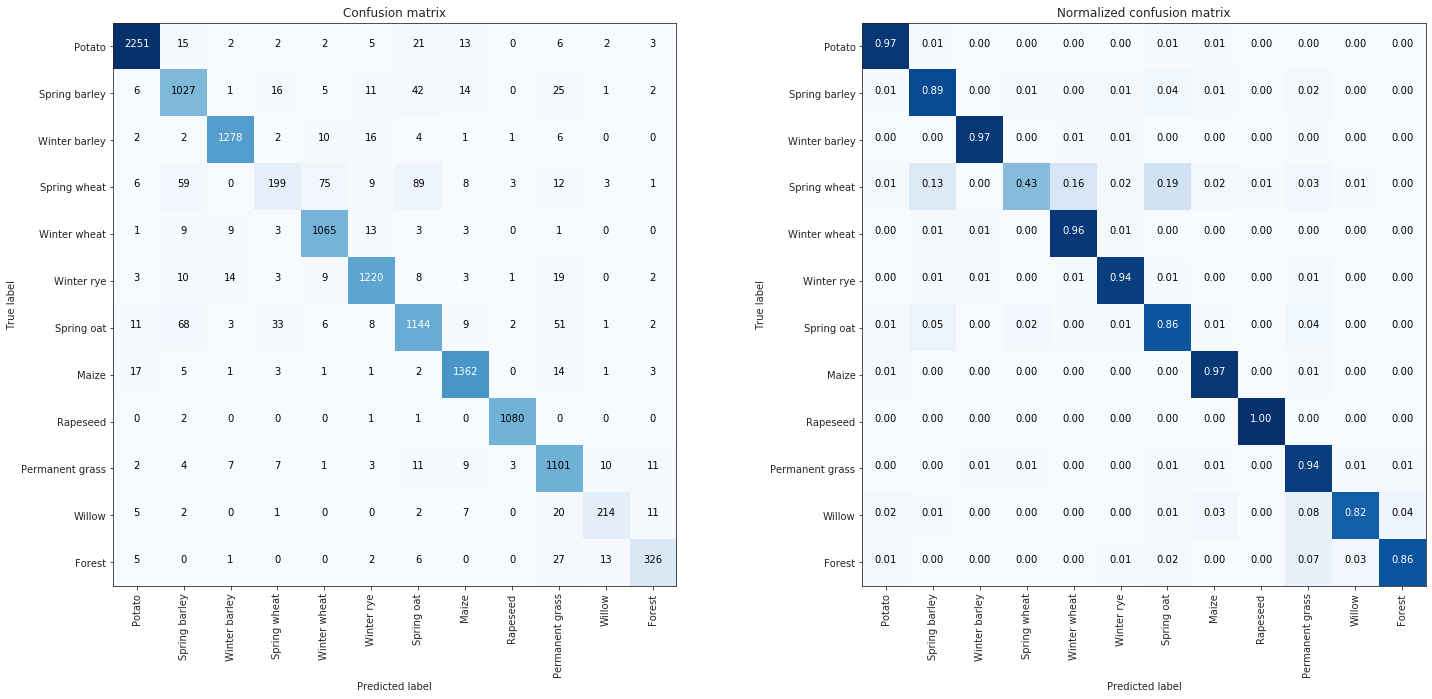

time: 1min 25s


In [12]:
from sklearn.linear_model import LogisticRegression          

# Instantiate classifier.
#clf = LogisticRegression(solver='newton-cg', max_iter=1000)
clf = LogisticRegression()

# Evaluate classifier without feature scaling
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

Training time: 56.7841 s
Prediction time: 0.0138 s

Report:

Train accuracy: 0.9799
Test accuracy: 0.915

                  precision    recall  f1-score   support

         Potato       0.98      0.97      0.97      2322
  Spring barley       0.86      0.88      0.87      1150
  Winter barley       0.97      0.96      0.96      1322
   Spring wheat       0.61      0.64      0.63       464
   Winter wheat       0.90      0.94      0.92      1107
     Winter rye       0.93      0.94      0.94      1292
     Spring oat       0.88      0.82      0.85      1338
          Maize       0.95      0.96      0.96      1410
       Rapeseed       0.99      0.99      0.99      1084
Permanent grass       0.86      0.88      0.87      1169
         Willow       0.83      0.81      0.82       262
         Forest       0.87      0.85      0.86       380

       accuracy                           0.91     13300
      macro avg       0.89      0.89      0.89     13300
   weighted avg       0.92      0.91

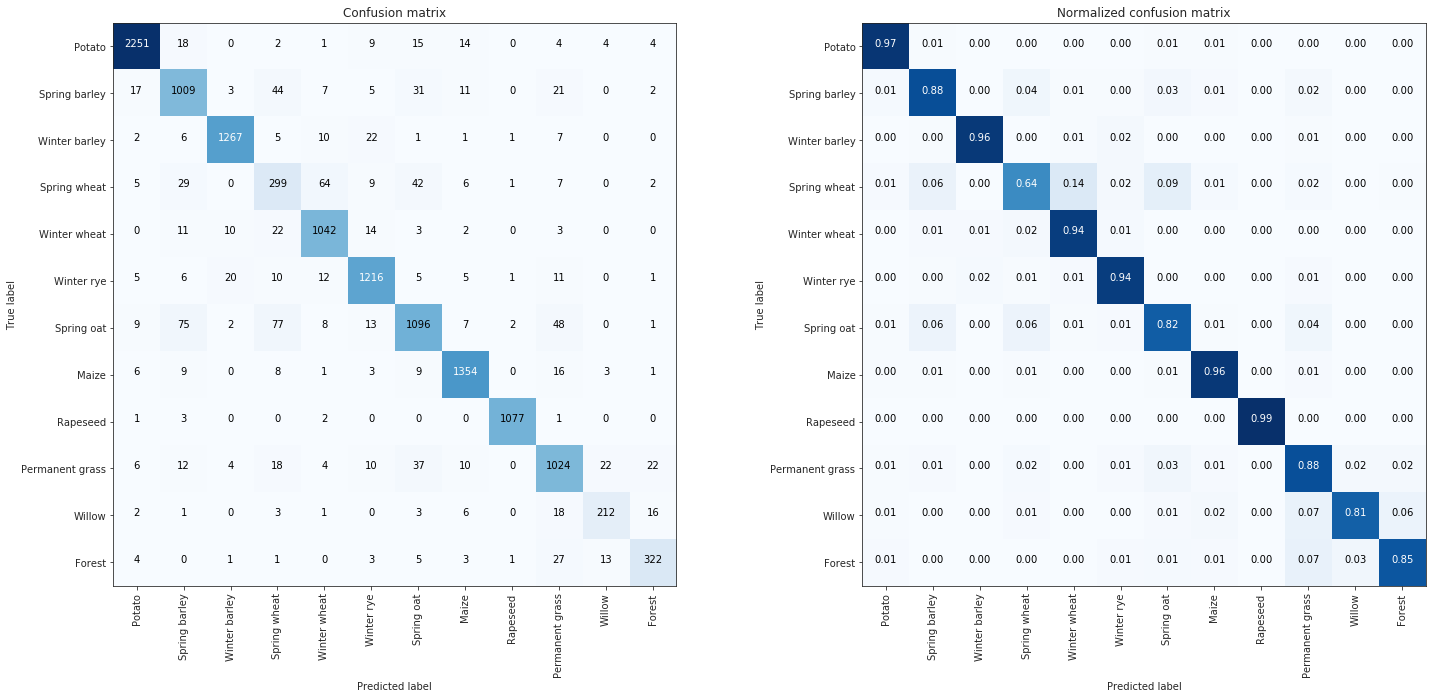

time: 58.3 s


In [13]:
from sklearn.neural_network import MLPClassifier

# Instantiate and evaluate classifier
clf = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(25, 25), max_iter=1000)  # See what happens when you change random state
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

Training time: 71.3339 s
Prediction time: 17.5945 s

Report:

Train accuracy: 0.9544
Test accuracy: 0.9198

                  precision    recall  f1-score   support

         Potato       0.96      0.97      0.97      2322
  Spring barley       0.85      0.90      0.87      1150
  Winter barley       0.96      0.96      0.96      1322
   Spring wheat       0.67      0.58      0.62       464
   Winter wheat       0.90      0.94      0.92      1107
     Winter rye       0.94      0.94      0.94      1292
     Spring oat       0.88      0.85      0.87      1338
          Maize       0.96      0.95      0.95      1410
       Rapeseed       0.99      0.99      0.99      1084
Permanent grass       0.89      0.92      0.90      1169
         Willow       0.83      0.81      0.82       262
         Forest       0.90      0.85      0.87       380

       accuracy                           0.92     13300
      macro avg       0.90      0.89      0.89     13300
   weighted avg       0.92      0.

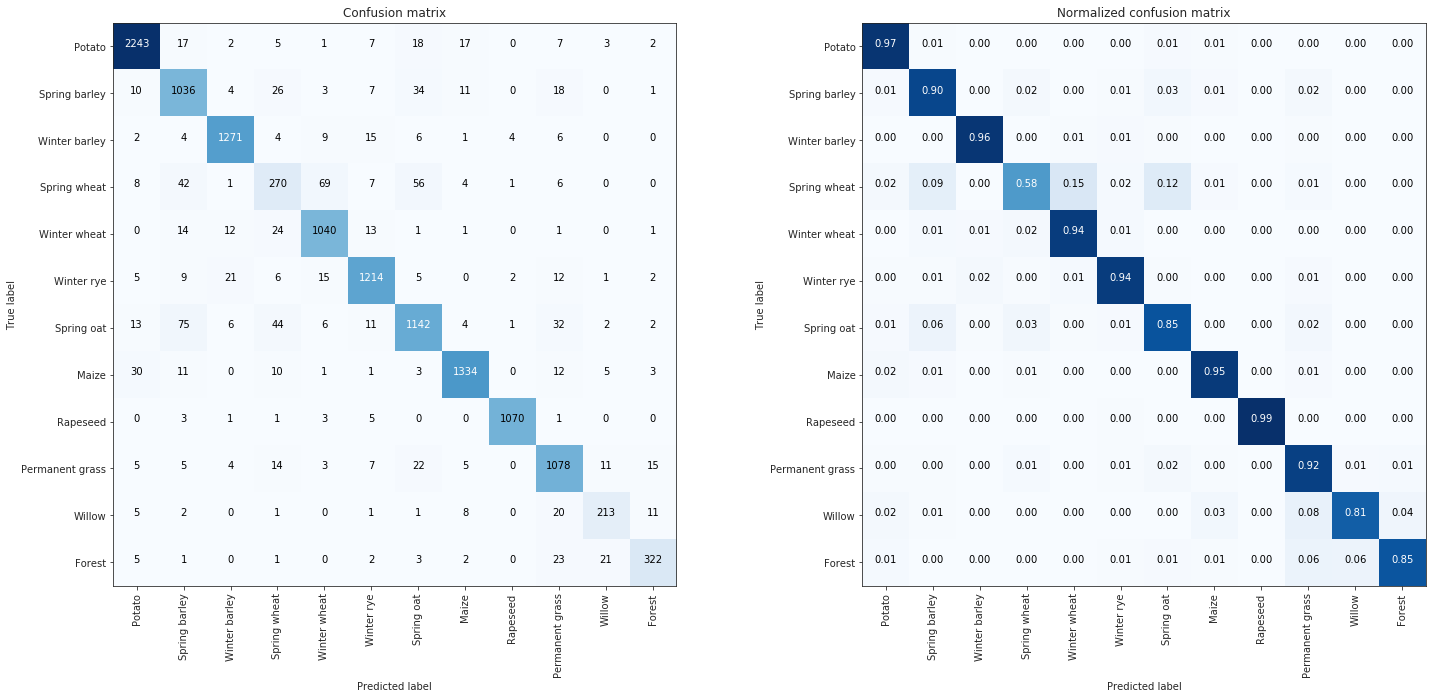

time: 2min 28s


In [14]:
from sklearn.svm import SVC   

# Instantiate and evaluate classifier
clf = SVC(kernel='linear')
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

Training time: 59.0712 s
Prediction time: 32.8698 s

Report:

Train accuracy: 0.9627
Test accuracy: 0.9429

                  precision    recall  f1-score   support

         Potato       0.98      0.98      0.98      2322
  Spring barley       0.90      0.91      0.91      1150
  Winter barley       0.99      0.98      0.98      1322
   Spring wheat       0.85      0.65      0.74       464
   Winter wheat       0.92      0.97      0.94      1107
     Winter rye       0.95      0.97      0.96      1292
     Spring oat       0.91      0.88      0.90      1338
          Maize       0.97      0.97      0.97      1410
       Rapeseed       1.00      1.00      1.00      1084
Permanent grass       0.88      0.96      0.92      1169
         Willow       0.89      0.85      0.87       262
         Forest       0.94      0.87      0.90       380

       accuracy                           0.94     13300
      macro avg       0.93      0.92      0.92     13300
   weighted avg       0.94      0.

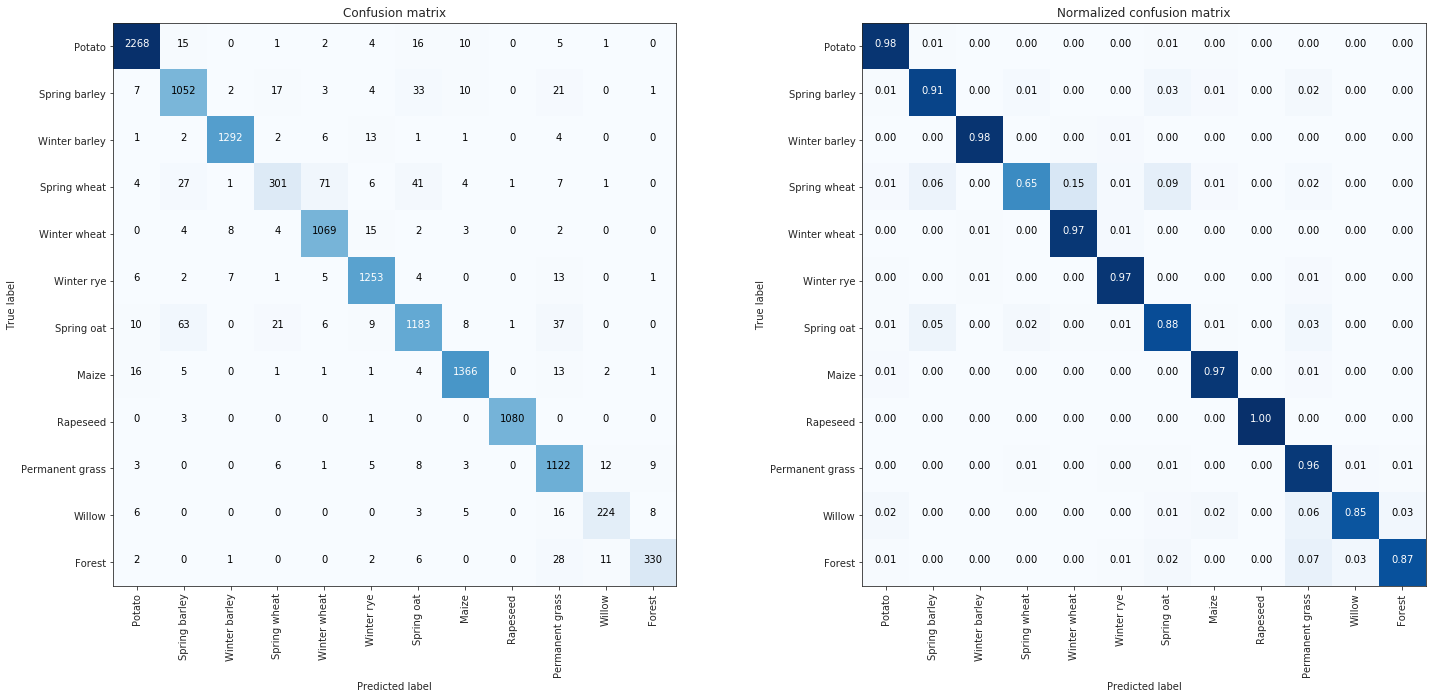

time: 3min 21s


In [15]:
# Instantiate and evaluate classifier
clf = SVC(kernel='rbf')
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

Training time: 60.931 s
Prediction time: 34.5956 s

Report:

Train accuracy: 0.965
Test accuracy: 0.9415

                  precision    recall  f1-score   support

         Potato       0.98      0.98      0.98      2322
  Spring barley       0.91      0.91      0.91      1150
  Winter barley       0.99      0.98      0.98      1322
   Spring wheat       0.72      0.74      0.73       464
   Winter wheat       0.93      0.96      0.95      1107
     Winter rye       0.96      0.97      0.96      1292
     Spring oat       0.94      0.86      0.89      1338
          Maize       0.97      0.97      0.97      1410
       Rapeseed       1.00      1.00      1.00      1084
Permanent grass       0.89      0.95      0.92      1169
         Willow       0.85      0.87      0.86       262
         Forest       0.91      0.87      0.89       380

       accuracy                           0.94     13300
      macro avg       0.92      0.92      0.92     13300
   weighted avg       0.94      0.94

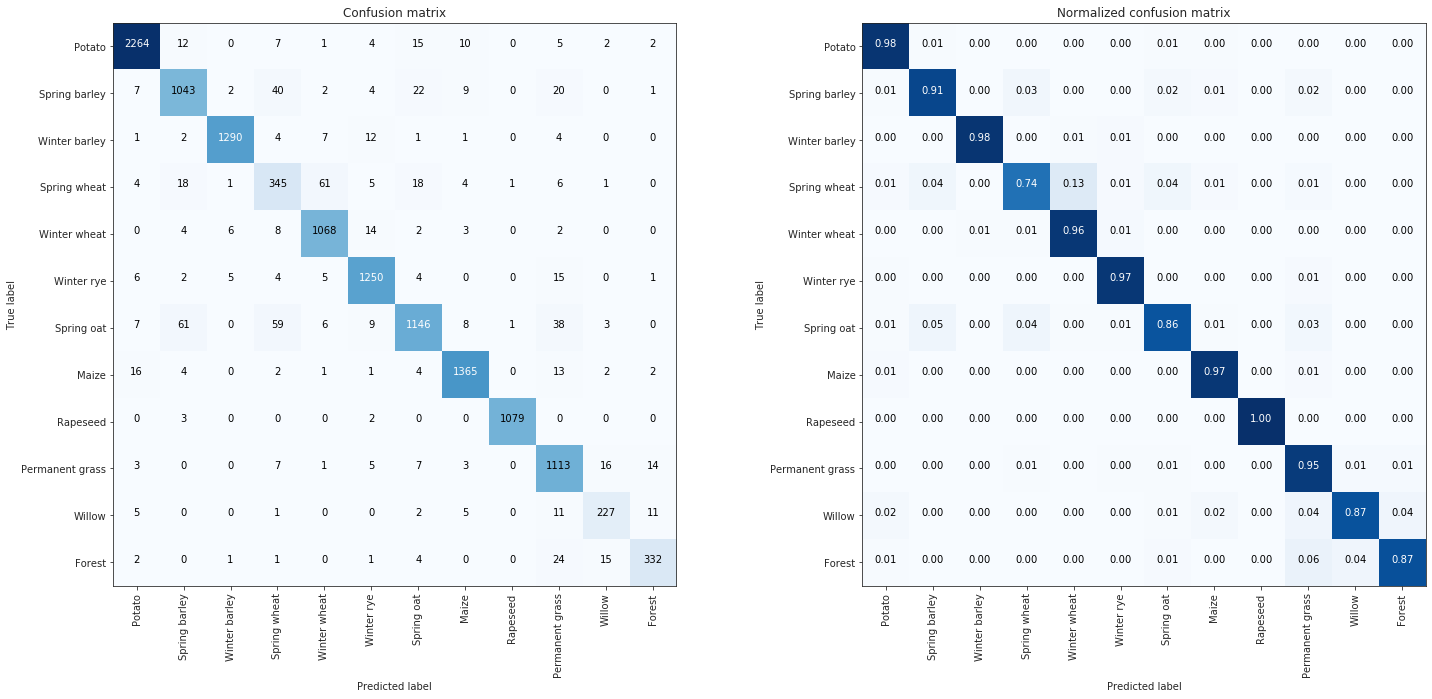

time: 3min 32s


In [16]:
# Instantiate and evaluate classifier
clf = SVC(kernel='rbf', class_weight='balanced')
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

In [17]:
try:  # If auto-sklearn is installed 
    import autosklearn.classification
except:  # Else install auto-sklearn (https://automl.github.io/auto-sklearn/master/installation.html and https://hub.docker.com/r/alfranz/automl/dockerfile) 
    !sudo apt-get update && sudo apt-get install -y swig curl
    !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install --default-timeout=100
    !pip install auto-sklearn

time: 230 ms


/opt/conda/lib/python3.7/site-packages/pyparsing.py:3174: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


[WARNING] [2020-04-26 17:15:17,670:EnsembleBuilder(1791095845):1a434e39915441259cc1e1b3d487f84c] No models better than random - using Dummy Score!
[WARNING] [2020-04-26 17:15:17,684:EnsembleBuilder(1791095845):1a434e39915441259cc1e1b3d487f84c] No models better than random - using Dummy Score!
[WARNING] [2020-04-26 17:15:19,690:EnsembleBuilder(1791095845):1a434e39915441259cc1e1b3d487f84c] No models better than random - using Dummy Score!
[WARNING] [2020-04-26 17:15:21,698:EnsembleBuilder(1791095845):1a434e39915441259cc1e1b3d487f84c] No models better than random - using Dummy Score!
[WARNING] [2020-04-26 17:15:23,707:EnsembleBuilder(1791095845):1a434e39915441259cc1e1b3d487f84c] No models better than random - using Dummy Score!
[WARNING] [2020-04-26 17:15:25,715:EnsembleBuilder(1791095845):1a434e39915441259cc1e1b3d487f84c] No models better than random - using Dummy Score!
[WARNING] [2020-04-26 17:15:27,720:EnsembleBuilder(1791095845):1a434e39915441259cc1e1b3d487f84c] No models better than

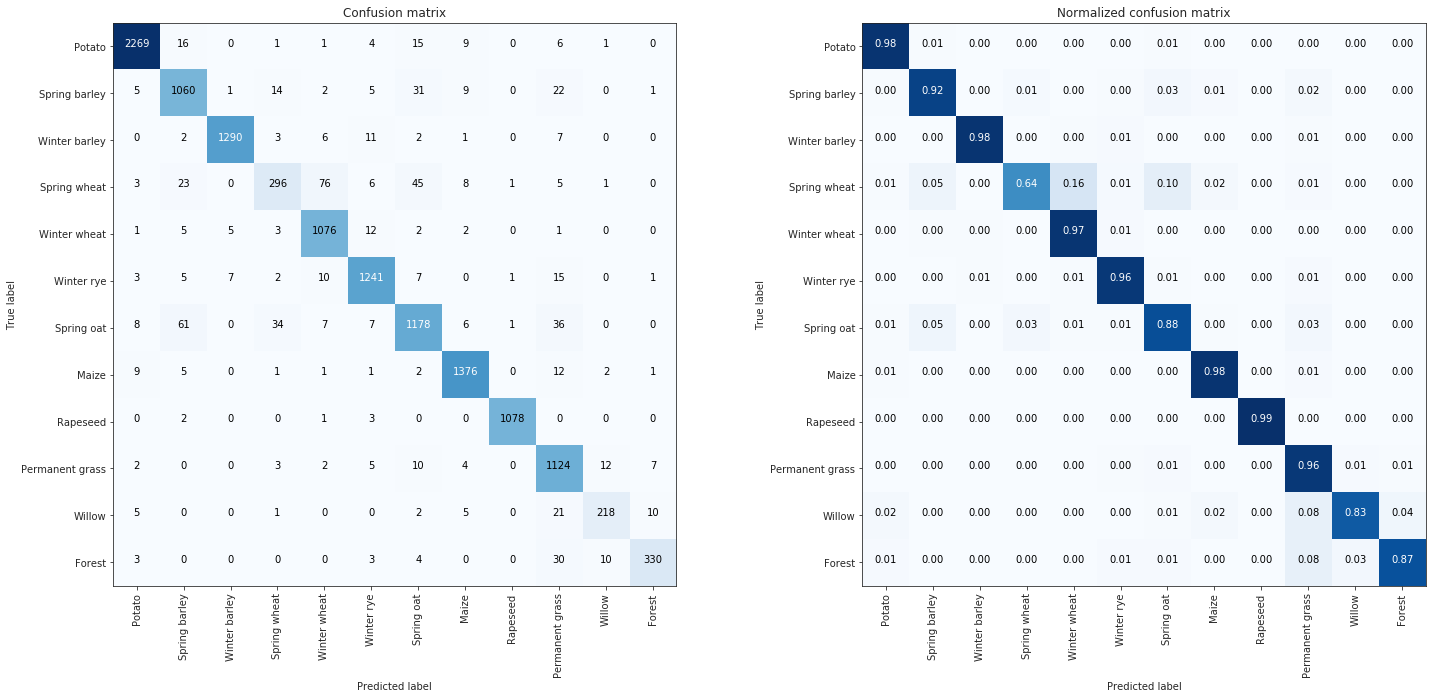

time: 3h 12min 27s


In [18]:
import autosklearn.classification

# Instantiate and evaluate classifier
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=7200, per_run_time_limit=720, 
                                                       ml_memory_limit=32768, n_jobs=12,  resampling_strategy='cv',
                                                       resampling_strategy_arguments={'folds': 5},)
#clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360, 
#                                                       ml_memory_limit=32768, n_jobs=24)
clf_trained, _, _, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True, auto_sklearn_crossvalidation=True)

# Then train the ensemble on the whole training dataset
# https://automl.github.io/auto-sklearn/master/examples/example_crossvalidation.html#sphx-glr-examples-example-crossvalidation-py

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:   41.6s
[Parallel(n_jobs=16)]: Done   2 out of   5 | elapsed:   41.7s remaining:  1.0min
[Parallel(n_jobs=16)]: Done   3 out of   5 | elapsed:   42.4s remaining:   28.3s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:   42.8s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:   42.8s finished


Training time: 76.4498 s
Prediction time: 23.1791 s

Report:

Train accuracy: 0.9631
Test accuracy: 0.9411

                  precision    recall  f1-score   support

         Potato       0.98      0.98      0.98      2251
  Spring barley       0.89      0.91      0.90      1187
  Winter barley       0.99      0.98      0.98      1311
   Spring wheat       0.81      0.62      0.70       482
   Winter wheat       0.91      0.98      0.94      1114
     Winter rye       0.96      0.96      0.96      1290
     Spring oat       0.90      0.88      0.89      1340
          Maize       0.98      0.98      0.98      1430
       Rapeseed       1.00      0.99      1.00      1121
Permanent grass       0.89      0.95      0.92      1135
         Willow       0.89      0.86      0.88       251
         Forest       0.93      0.85      0.89       388

       accuracy                           0.94     13300
      macro avg       0.93      0.91      0.92     13300
   weighted avg       0.94      0.

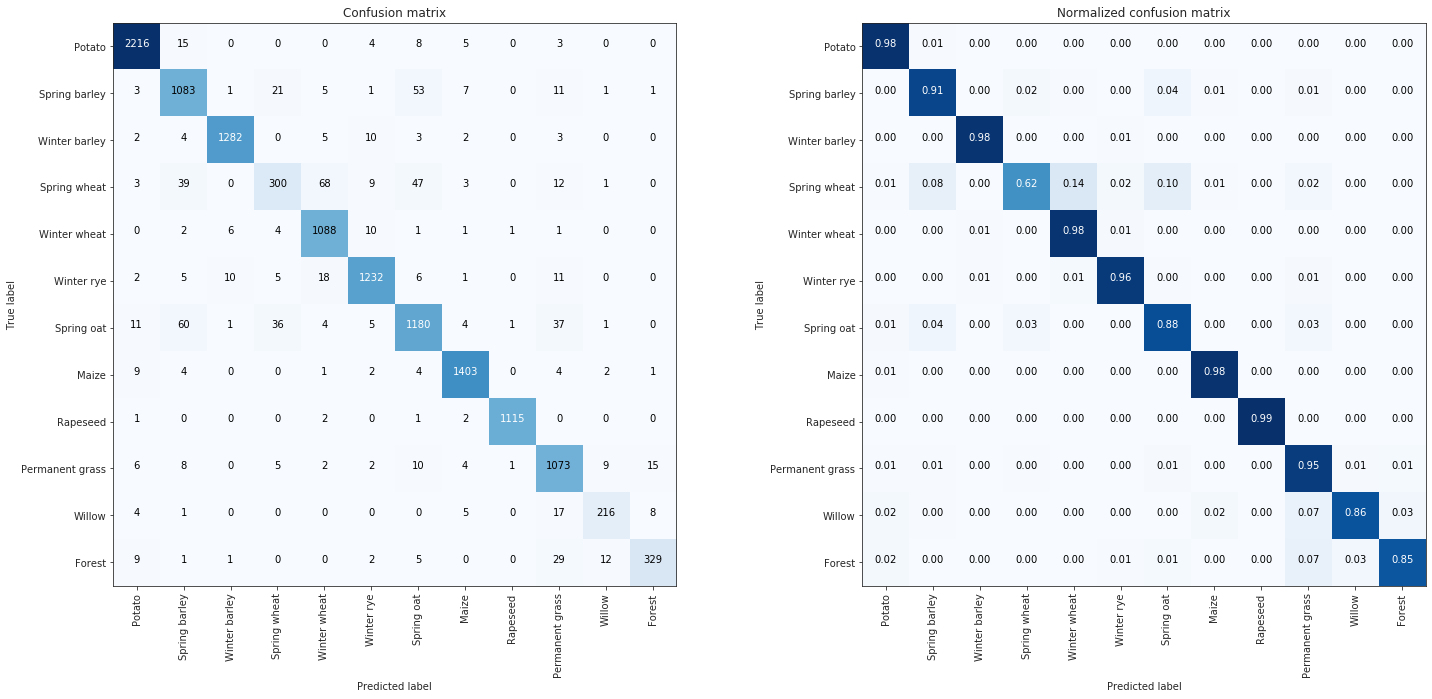

time: 2min 58s


In [32]:
# Take a look at https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29
from sklearn.svm import SVC   
from sklearn.model_selection import GridSearchCV
#param_grid = {'C': [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7], 
#              'gamma': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
#              'kernel': ['rbf']}
param_grid = {'C': [1e1], 
              'gamma': [1e-3], 
              'kernel': ['rbf']}
#grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, cv=5, verbose=20, n_jobs=32)
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=20, n_jobs=16)
grid_trained, _, _, results_report, cnf_matrix = evaluate_classifier(grid, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

print(f"The best parameters are {grid_trained.best_params_} with a score of {grid_trained.best_score_:2f}")

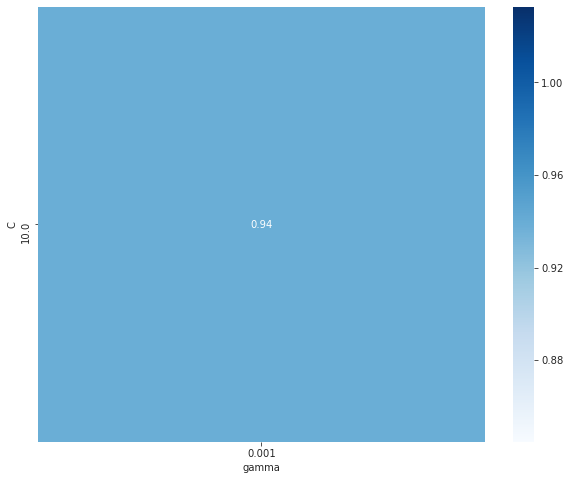

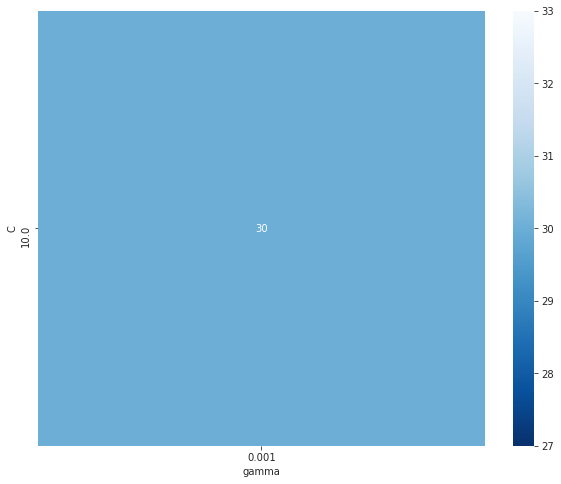

time: 284 ms


In [33]:
# Idea: Maybe make a utils folder, with a plotting module, evaluation module etc.. The below here should 
#       then be put in the plotting module. 
mean_test_scores = grid_trained.cv_results_['mean_test_score']
mean_fit_times = grid_trained.cv_results_['mean_fit_time']
param_columns = list(grid_trained.cv_results_['params'][0].keys())
result_columns = ['mean_fit_time', 'mean_test_score']
num_fits = len(grid_trained.cv_results_['params'])

df_cv_results = pd.DataFrame(0, index=range(num_fits), columns=param_columns+result_columns)
for i, param_set in enumerate(grid_trained.cv_results_['params']):
    for param, value in param_set.items():
        df_cv_results.loc[i, param] = value 
    df_cv_results.loc[i, 'mean_test_score'] = mean_test_scores[i]
    df_cv_results.loc[i, 'mean_fit_time'] = mean_fit_times[i]
    
df_heatmap_mean_score = df_cv_results.pivot(index='C', columns='gamma', values='mean_test_score')
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_heatmap_mean_score, annot=True, cmap=plt.cm.Blues)

df_heatmap_fit_time = df_cv_results.pivot(index='C', columns='gamma', values='mean_fit_time')
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_heatmap_fit_time.astype('int64'), annot=True, fmt='d', cmap=plt.cm.Blues_r)

In [52]:
# Get classfication report as pandas df
df_results = pd.DataFrame(results_report).transpose()  

# THIS IS WRONG! IT IS RECALL WE ARE CALCULATING!
# Get class-wise accuracy from confusion matrix
#class_wise_acc = cnf_matrix.diagonal()/cnf_matrix.sum(axis=1)

# Get macro avg of accuracies
#macro_avg_acc = np.average(class_wise_acc)

# Get weighted avg of accuracies
#samples = df_results.support.values[:-3]  # Bottom 3 rows are acc., macro avg and weighted avg in report
#weights = samples / np.sum(samples)
#weighted_avg_acc = np.average(class_wise_acc, weights=weights)

# Drop the accuracies row
#df_results = df_results[df_results.index != 'accuracy']

# Add accuracies column
#acc_column_values = np.append(class_wise_acc, [macro_avg_acc, weighted_avg_acc])
#df_results.insert (0, 'Acc.', acc_column_values)

# Round the values to 2 decimals
df_results = df_results.astype({'support': 'int32'}).round(2) 

# Remove samples from 'macro avg' and 'weighed avg'
df_results.loc[df_results.index == 'accuracy', 'precision'] = ''  
df_results.loc[df_results.index == 'accuracy', 'recall'] = ''  
df_results.loc[df_results.index == 'accuracy', 'support'] = df_results.loc[df_results.index == 'macro avg', 'support'].values
#df_results.loc[df_results.index == 'weighted avg', 'support'] = ''  
#df_results.loc[df_results.index == 'macro avg', 'support'] = ''  

# Rename the support column to 'samples'
df_results = df_results.rename(columns={'precision': 'Prec.',
                                        'recall': 'Recall',
                                        'f1-score': 'F1-score',
                                        'support': 'Samples'},
                               index={'accuracy': 'Overall acc.',
                                      'macro avg': 'Macro avg.',
                                      'weighted avg': 'Weighted avg.'})


# Print df in latex format (I normally add a /midrule above 'Macro avg.')
pd.options.display.float_format = '{:.2f}'.format  # Show 2 decimals
print(df_results.to_latex(index=True))  

\begin{tabular}{lllrr}
\toprule
{} & Prec. & Recall &  F1-score &  Samples \\
\midrule
Potato          &  0.98 &   0.98 &      0.98 &     2251 \\
Spring barley   &  0.89 &   0.91 &      0.90 &     1187 \\
Winter barley   &  0.99 &   0.98 &      0.98 &     1311 \\
Spring wheat    &  0.81 &   0.62 &      0.70 &      482 \\
Winter wheat    &  0.91 &   0.98 &      0.94 &     1114 \\
Winter rye      &  0.96 &   0.96 &      0.96 &     1290 \\
Spring oat      &  0.90 &   0.88 &      0.89 &     1340 \\
Maize           &  0.98 &   0.98 &      0.98 &     1430 \\
Rapeseed        &  1.00 &   0.99 &      1.00 &     1121 \\
Permanent grass &  0.89 &   0.95 &      0.92 &     1135 \\
Willow          &  0.89 &   0.86 &      0.88 &      251 \\
Forest          &  0.93 &   0.85 &      0.89 &      388 \\
Overall acc.    &       &        &      0.94 &    13300 \\
Macro avg.      &  0.93 &   0.91 &      0.92 &    13300 \\
Weighted avg.   &  0.94 &   0.94 &      0.94 &    13300 \\
\bottomrule
\end{tabular}

t

-------------------------------------------------------------------------------
Evaluating classifier: Nearest Neighbors
Training time: 0.7725 s
Prediction time: 191.2214 s

Report:

Train accuracy: 0.9463
Test accuracy: 0.9041

                  precision    recall  f1-score   support

         Potato       0.98      0.96      0.97      2251
  Spring barley       0.78      0.84      0.81      1187
  Winter barley       0.95      0.94      0.95      1311
   Spring wheat       0.60      0.47      0.53       482
   Winter wheat       0.89      0.93      0.91      1114
     Winter rye       0.94      0.93      0.94      1290
     Spring oat       0.88      0.79      0.83      1340
          Maize       0.91      0.97      0.94      1430
       Rapeseed       1.00      0.99      1.00      1121
Permanent grass       0.87      0.91      0.89      1135
         Willow       0.86      0.84      0.85       251
         Forest       0.86      0.88      0.87       388

       accuracy            

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 0.1672 s
Prediction time: 0.0153 s

Report:

Train accuracy: 0.6835
Test accuracy: 0.6731

                  precision    recall  f1-score   support

         Potato       0.71      0.97      0.82      2251
  Spring barley       0.66      0.33      0.44      1187
  Winter barley       0.64      0.79      0.70      1311
   Spring wheat       0.00      0.00      0.00       482
   Winter wheat       0.75      0.34      0.47      1114
     Winter rye       0.60      0.73      0.66      1290
     Spring oat       0.55      0.42      0.48      1340
          Maize       0.66      0.79      0.72      1430
       Rapeseed       0.88      0.97      0.92      1121
Permanent grass       0.58      0.77      0.66      1135
         Willow       0.91      0.24      0.37       251
         Forest       0.89      0.80      0.84       388

       accuracy                  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------------------------------------------------
Evaluating classifier: Neural Net
Training time: 16.7814 s
Prediction time: 0.0167 s

Report:

Train accuracy: 0.9454
Test accuracy: 0.9377

                  precision    recall  f1-score   support

         Potato       0.98      0.98      0.98      2251
  Spring barley       0.89      0.91      0.90      1187
  Winter barley       0.98      0.98      0.98      1311
   Spring wheat       0.80      0.60      0.68       482
   Winter wheat       0.90      0.97      0.94      1114
     Winter rye       0.96      0.94      0.95      1290
     Spring oat       0.91      0.88      0.89      1340
          Maize       0.96      0.98      0.97      1430
       Rapeseed       1.00      0.99      1.00      1121
Permanent grass       0.87      0.95      0.91      1135
         Willow       0.88      0.86      0.87       251
         Forest       0.95      0.83      0.89       388

       accuracy                    

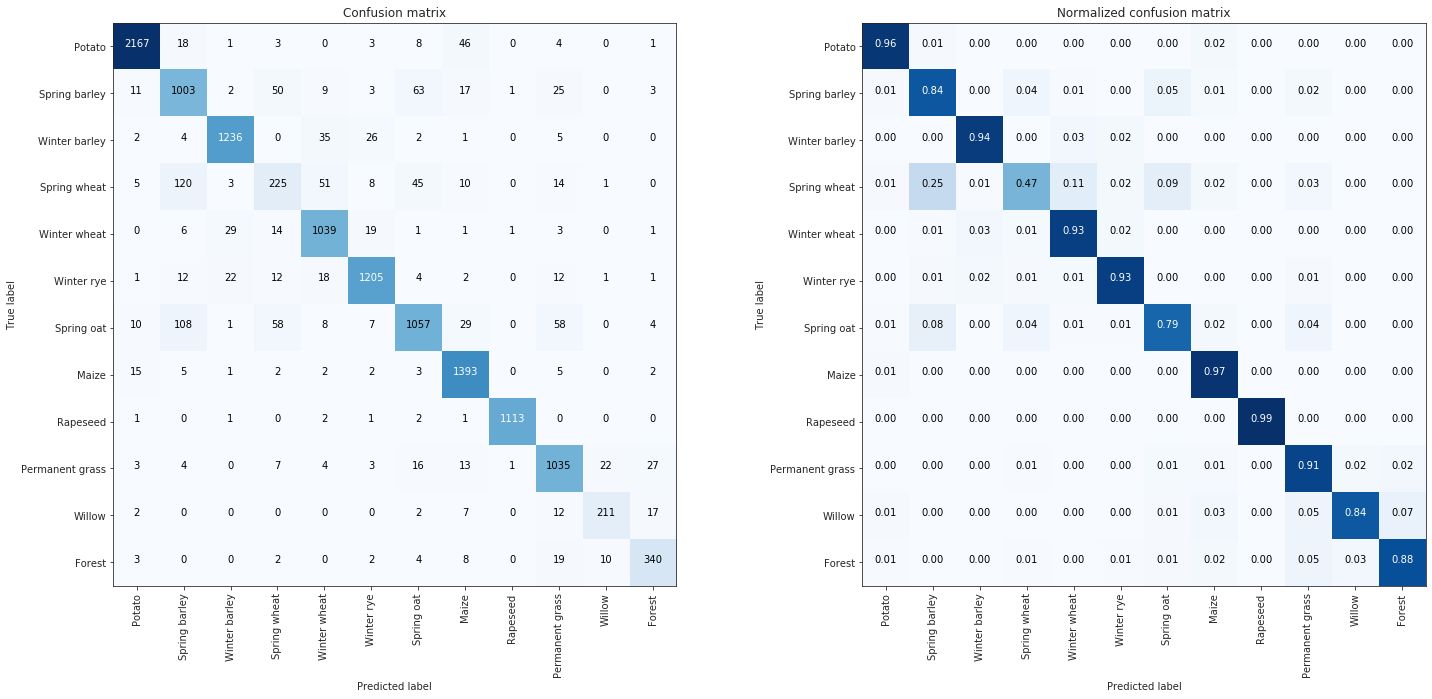

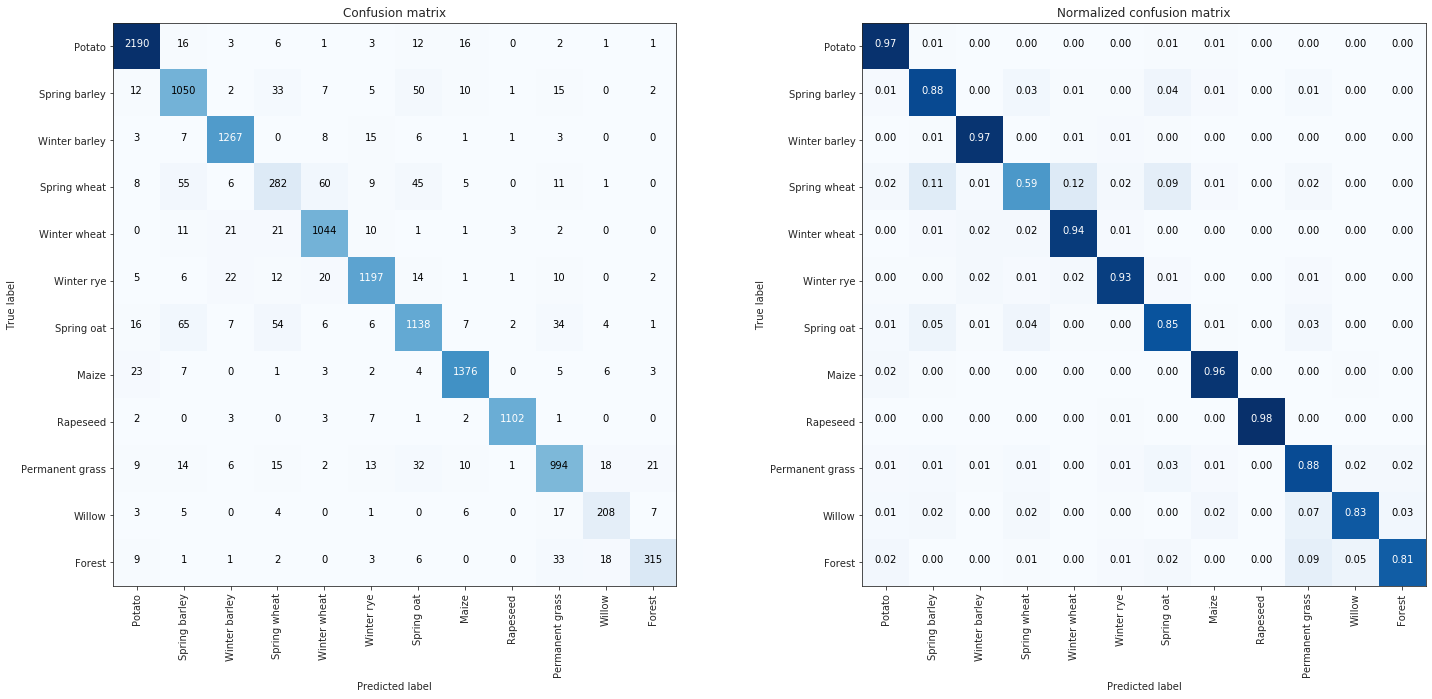

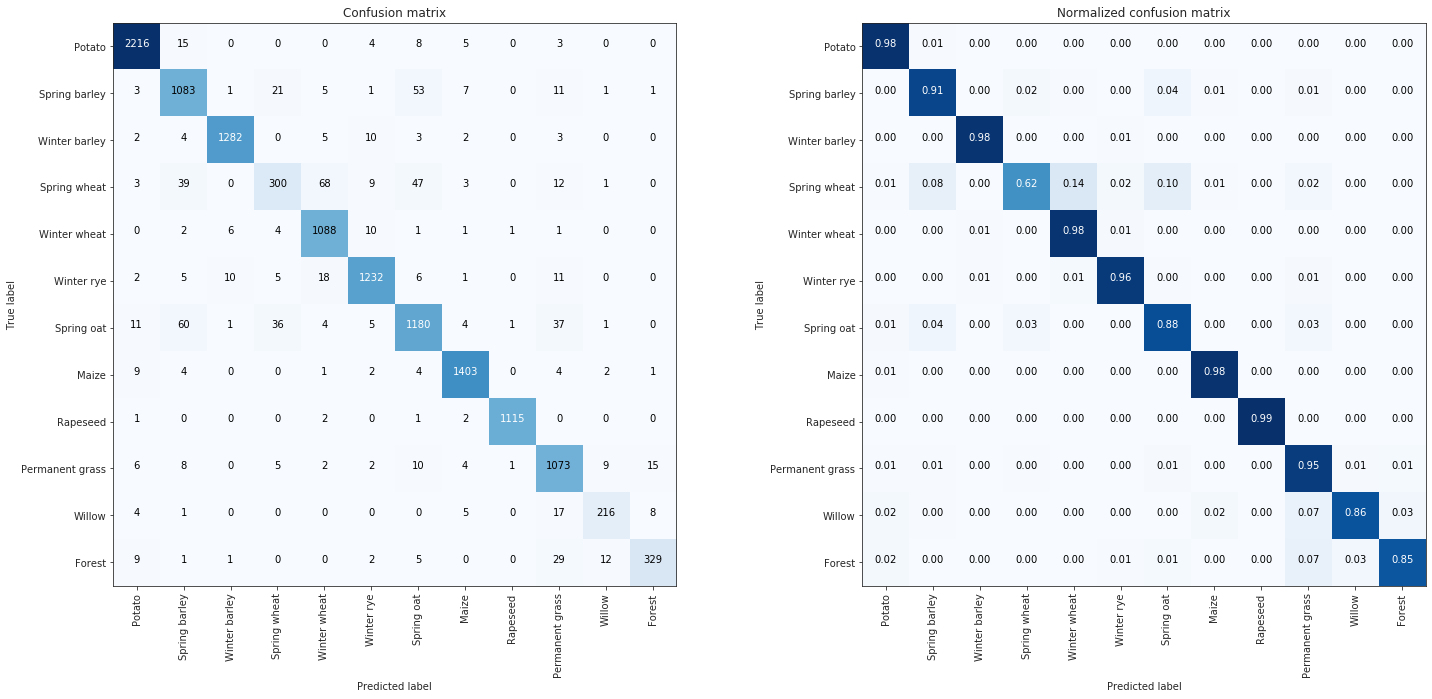

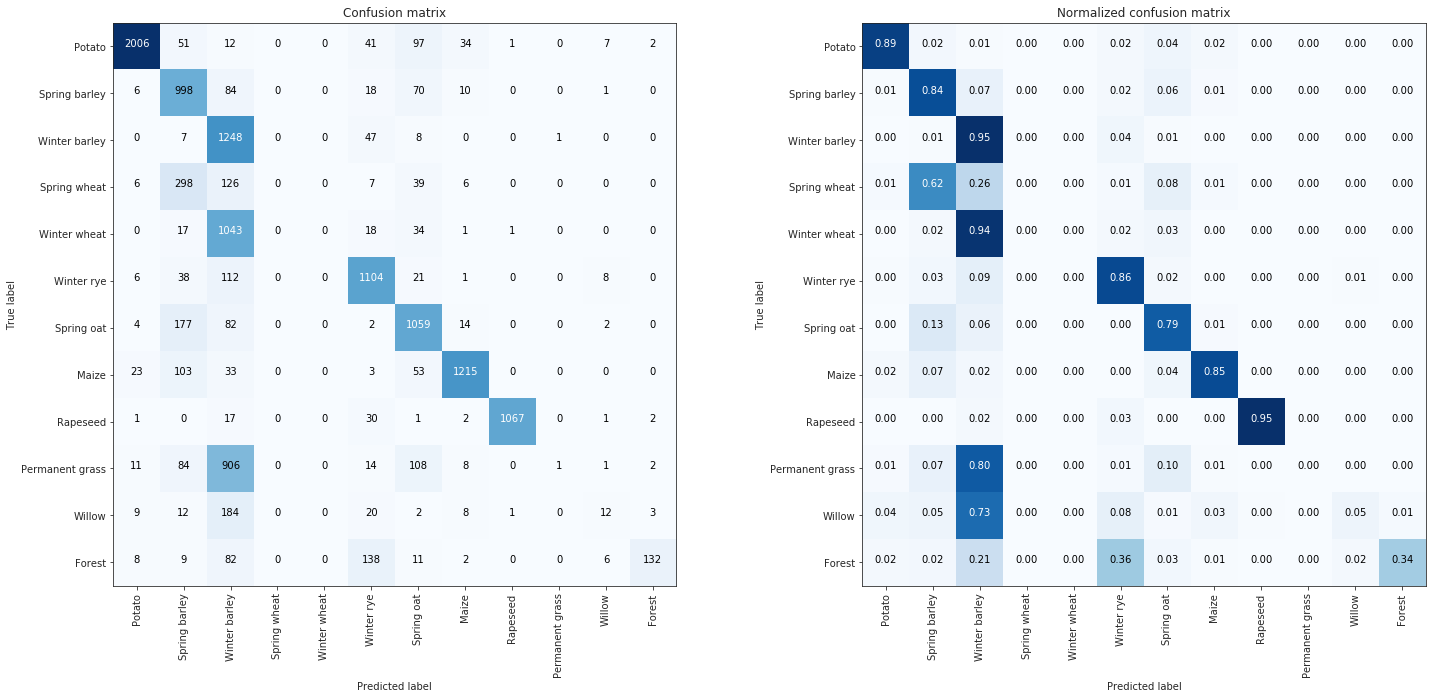

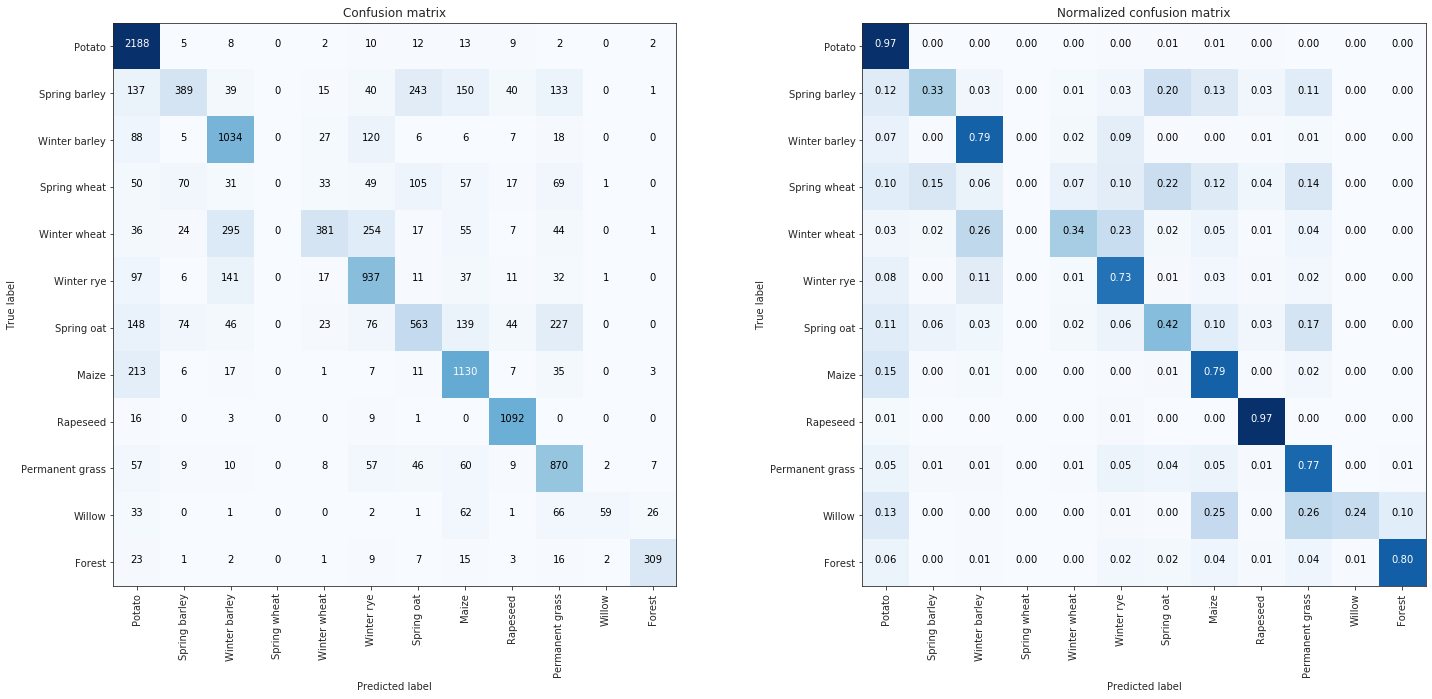

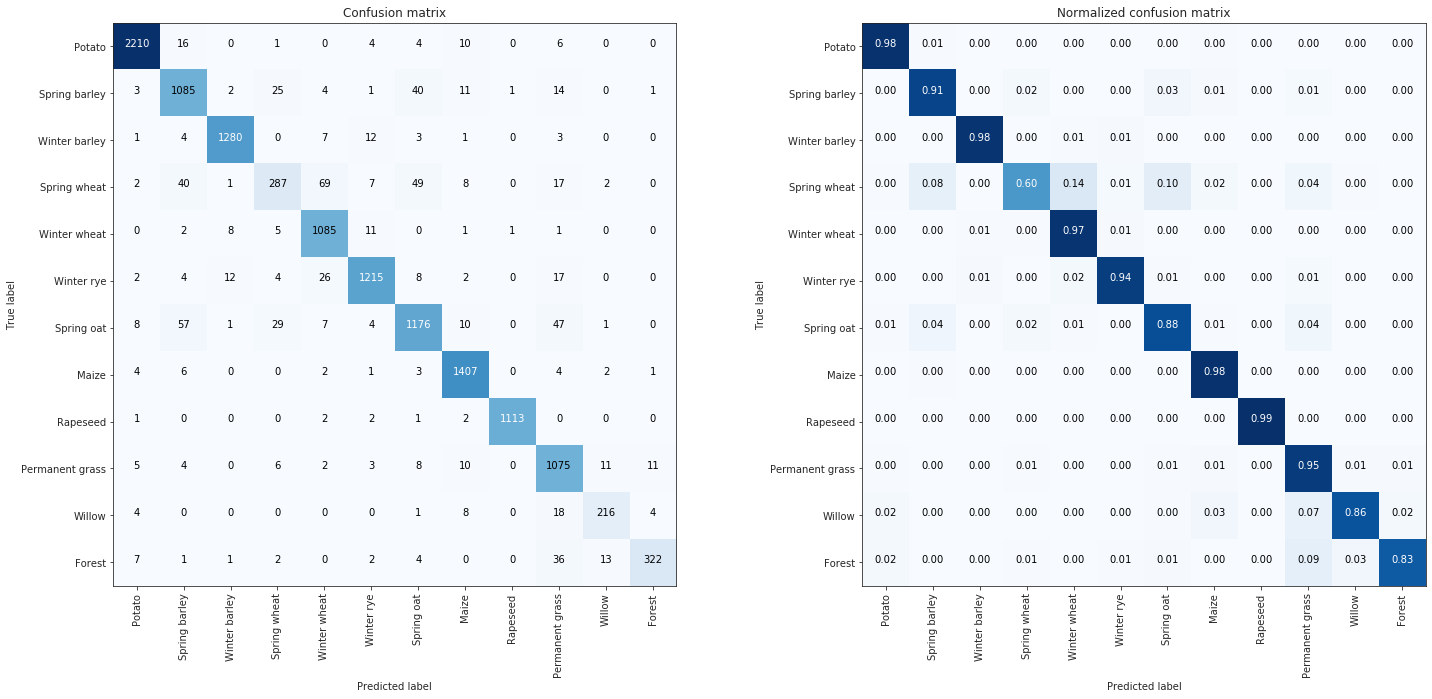

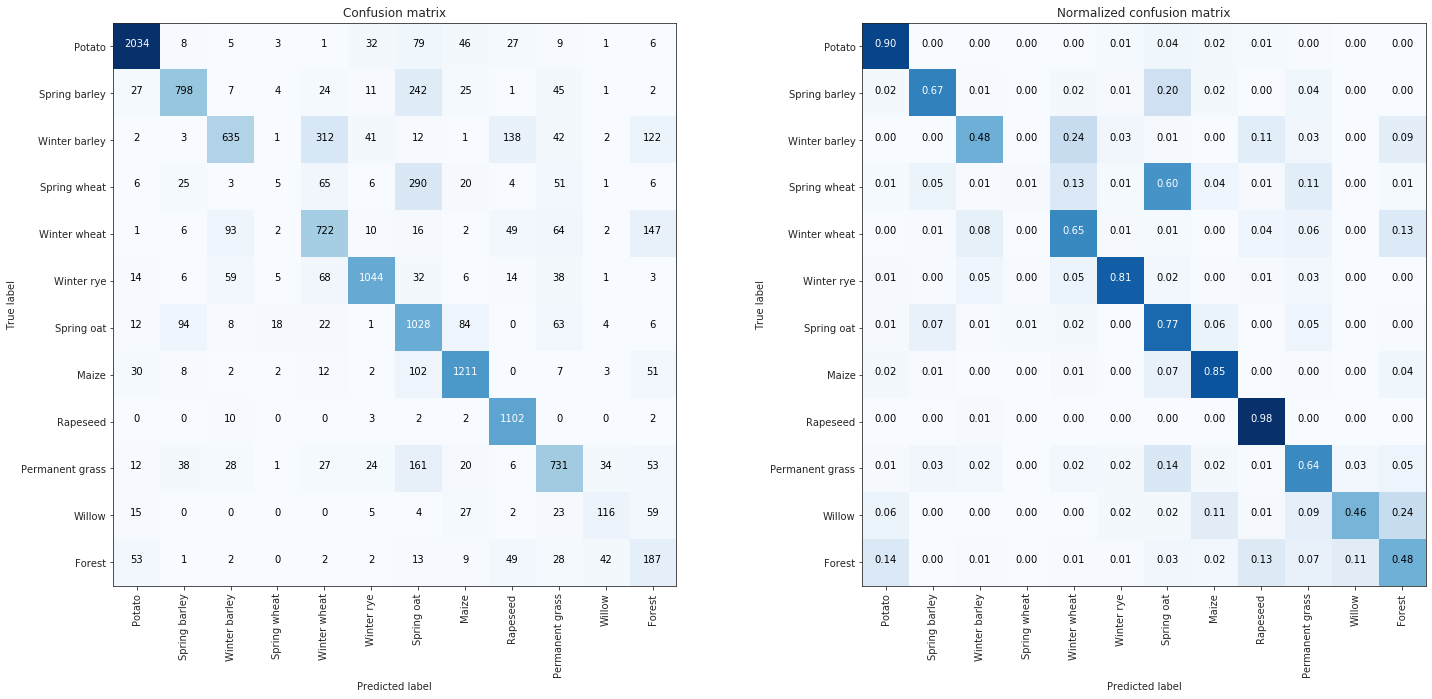

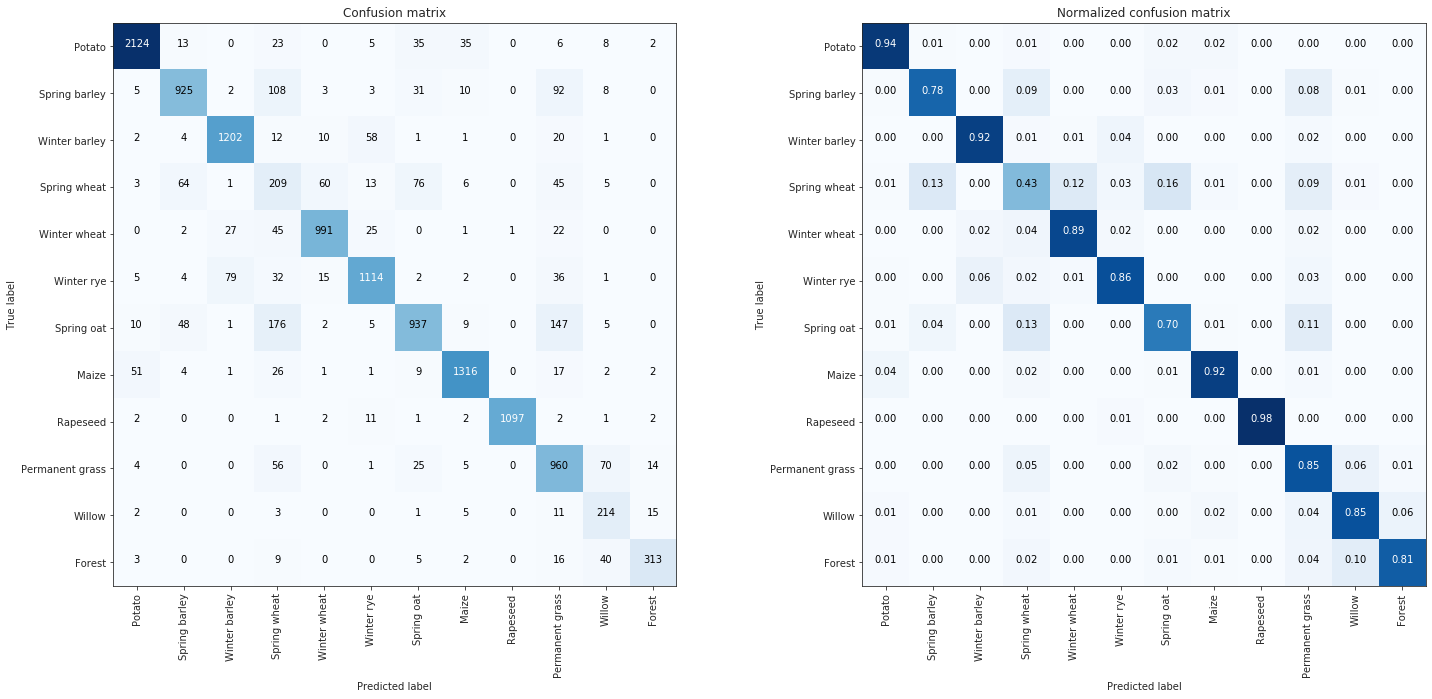

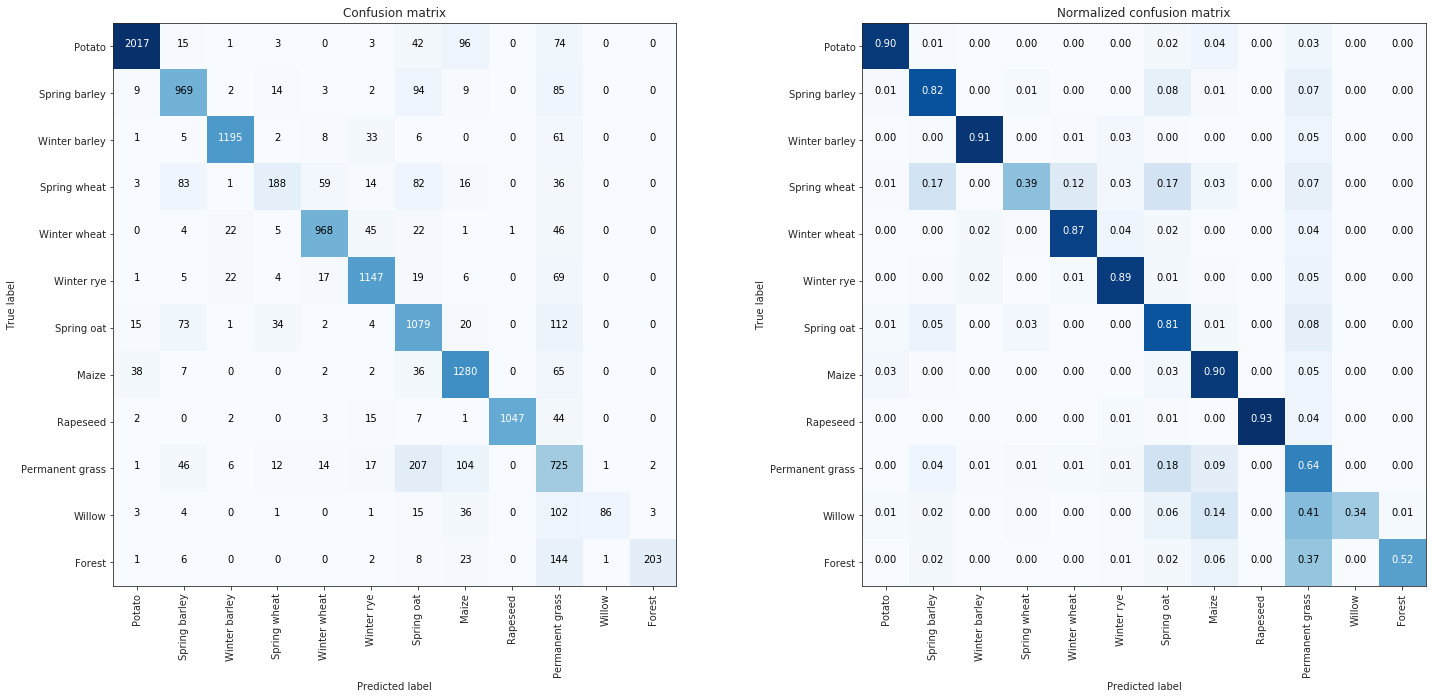

time: 22min 52s


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# Note: GaussianClassifier does not work (maybe requires too much training - kernel restarts in jupyter)
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=10),
    SVC(gamma=0.001, C=10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# TODO: Also calculate uncertainties - ie. use multiple random seeds.
#       Create df (with cols [Clf_name, Random_seed, Acc., Prec., Recall, F1-score]) and loop over random seeds
#       See following on how to format pandas dataframe to get the uncertainties into the df
#       https://stackoverflow.com/questions/46584736/pandas-change-between-mean-std-and-plus-minus-notations

for name, clf in zip(names, classifiers):
    print("-------------------------------------------------------------------------------")
    print(f"Evaluating classifier: {name}")
    clf_trained, _, _, results_report, cnf_matrix = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)      

In [16]:
try:
    from pycm import ConfusionMatrix
except:
    !pip install pycm
    from pycm import ConfusionMatrix

def numpy_confusion_matrix_to_pycm(confusion_matrix_numpy, labels=None):
    """Create a pycm confusion matrix from a NumPy confusion matrix
    Creates a confusion matrix object with the pycm library based on a confusion matrix as 2D NumPy array (such as
    the one generated by the sklearn confusion matrix function).
    See more about pycm confusion matrices at `pycm`_, and see more
    about sklearn confusion matrices at `sklearn confusion matrix`_.
    Args:
        confusion_matrix_numpy (np.array((num_classes, num_classes)) :
        labels (list) :
    Returns:
        confusion_matrix_pycm (pycm.ConfusionMatrix) :
    .. _`pycm`: https://github.com/sepandhaghighi/pycm
    .. _`sklearn confusion matrix`:
        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    """
    # Create empty dict to be used as input for pycm (see https://github.com/sepandhaghighi/pycm#direct-cm)
    confusion_matrix_dict = {}

    # Find number and classes and check labels
    num_classes = np.shape(confusion_matrix_numpy)[0]
    if not labels:  # If no labels are provided just use [0, 1, ..., num_classes]
        labels = range(num_classes)
    elif len(labels) != num_classes:
        raise AttributeError("Number of provided labels does not match number of classes.")

    # Fill the dict in the format required by pycm with values from the sklearn confusion matrix
    for row in range(num_classes):
        row_dict = {}
        for col in range(num_classes):
            row_dict[str(labels[col])] = int(confusion_matrix_numpy[row, col])
        confusion_matrix_dict[str(labels[row])] = row_dict

    # Instantiate the pycm confusion matrix from the dict
    confusion_matrix_pycm = ConfusionMatrix(matrix=confusion_matrix_dict)

    return confusion_matrix_pycm

time: 28.4 ms


In [27]:
pycm_confusion_matrix = numpy_confusion_matrix_to_pycm(cnf_matrix, labels=class_names)
print(pycm_confusion_matrix.ACC)

{'Forest': 0.9857142857142858, 'Maize': 0.9652631578947368, 'Permanent grass': 0.9061654135338346, 'Potato': 0.9768421052631578, 'Rapeseed': 0.9943609022556391, 'Spring barley': 0.9649624060150376, 'Spring oat': 0.9399248120300752, 'Spring wheat': 0.9722556390977444, 'Willow': 0.9874436090225563, 'Winter barley': 0.9869924812030075, 'Winter rye': 0.9788721804511278, 'Winter wheat': 0.9809022556390977}
time: 39.4 ms


In [31]:
pycm_confusion_matrix.stat()

Overall Statistics : 

95% CI                                                            (0.81332,0.82638)
ACC Macro                                                         0.96997
ARI                                                               0.69159
AUNP                                                              0.90055
AUNU                                                              0.863
Bennett S                                                         0.80347
CBA                                                               0.70724
CSI                                                               0.58506
Chi-Squared                                                       89608.54455
Chi-Squared DF                                                    121
Conditional Entropy                                               0.95203
Cramer V                                                          0.78262
Cross Entropy                                                     3.45148
F1 Macr